In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler

label_encoding = {
    "fall": 0, "run": 1, "walk": 2, "cycle": 3, "lay": 4, "squat": 5, "mop": 6, "drink": 7, "sweep": 8,
    "brushing_teeth": 9, "cut": 10, "eat": 11, "folding_clothes": 12, "hang_out_clothes": 13, "ironing": 14,
    "open_door": 15, "open_fridge": 16, "sit": 17, "stand": 18, "use_computer": 19, "wash_dish": 20,
    "wash_face": 21, "wash_window": 22, "watch_tv": 23, "watering_flowers": 24, "write": 25, "wc": 26,
    "play_phone": 27, "switch": 28
}

rev_label_encoding = {
    0: "fall", 1: "run", 2: "walk", 3: "cycle", 4: "lay", 5: "squat", 6: "mop", 7: "drink", 8: "sweep",
    9: "brushing_teeth", 10: "cut", 11: "eat", 12: "folding_clothes", 13: "hang_out_clothes", 14: "ironing", 
    15: "open_door", 16: "open_fridge", 17: "sit", 18: "stand", 19: "use_computer", 20: "wash_dish", 
    21: "wash_face", 22: "wash_window", 23: "watch_tv", 24: "watering_flowers", 25: "write", 26: "wc", 
    27: "play_phone", 28: "switch"
}

# Function to print summary statistics
def print_summary(data, stage):
    print(f"\n--- {stage} Data Summary ---\n")
    print(data.describe())
    print("\nMissing values check:\n", data.isnull().sum())

# Function to read and concatenate all data files
def read_files(base_dir):
    all_data = []
    for subject_folder in os.listdir(base_dir):
        subject_path = os.path.join(base_dir, subject_folder)
        if os.path.isdir(subject_path):
            subject_number = int(subject_folder.split("_")[-1])
            for csv_file in os.listdir(subject_path):
                if csv_file.endswith("arm_r.csv"):
                    file_path = os.path.join(subject_path, csv_file)
                    df = pd.read_csv(file_path)
                    df["subject"] = subject_number
                    df["body_part"] = csv_file.split(".")[0]
                    all_data.append(df)
    return pd.concat(all_data, ignore_index=True)

# Function to normalize features
def normalize_features(data):
    scaler = StandardScaler()
    columns_to_normalize = ["ax", "ay", "az", "wx", "wy", "wz", "ex", "ey", "ez"]
    data[columns_to_normalize] = scaler.fit_transform(data[columns_to_normalize])
    return data

# Function to encode activity labels
def encode_labels(data):
    data["encoded_label"] = data["label"].map(label_encoding)
    return data

# Function to apply sliding window to the data
def apply_sliding_window(data, window_size=100, step_size=50):
    windows = []
    labels = []
    for i in range(0, len(data) - window_size + 1, step_size):
        window = data.iloc[i:i + window_size]
        windows.append(window[["ax", "ay", "az", "wx", "wy", "wz", "ex", "ey", "ez"]].values.flatten())
        labels.append(window["encoded_label"].mode().values[0])  # Most common label in the window
    return np.array(windows), np.array(labels)

# Function to visualize class distribution using activity names
def visualize_class_distribution(data, stage, save_path):
    # Count the occurrence of each activity name (label)
    activity_order = data["label"].value_counts().index

    plt.figure(figsize=(12, 6))
    sns.countplot(x="label", data=data, order=activity_order)
    plt.title(f"Activity Class Distribution ({stage})", fontsize=16)
    plt.xlabel("Activity Name", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, transparent=True)
    plt.show()

# Function to visualize dataset after applying sliding window
def visualize_window_distribution(labels, stage, save_path):
    unique, counts = np.unique(labels, return_counts=True)
    label_counts = dict(zip(unique, counts))

    # Convert label counts to activity names
    activity_names = [rev_label_encoding[label] for label in label_counts.keys()]

    plt.figure(figsize=(12, 6))
    sns.barplot(x=activity_names, y=list(label_counts.values()), palette="viridis")
    plt.title(f"Sliding Window Activity Distribution ({stage})", fontsize=16)
    plt.xlabel("Activity Name", fontsize=14)
    plt.ylabel("Count", fontsize=14)
    plt.xticks(rotation=90)
    plt.tight_layout()
    plt.savefig(save_path, dpi=300, transparent=True)
    plt.show()



In [2]:
base_dir = "../Datasets/CAPP Dataset/data"
data = read_files(base_dir)

In [3]:
# Print summary before preprocessing
print_summary(data, "Before Preprocessing")



--- Before Preprocessing Data Summary ---

               time            ax            ay            az            wx  \
count  5.976945e+06  5.976945e+06  5.976945e+06  5.976945e+06  5.976945e+06   
mean   1.678110e+12 -8.815476e-02 -8.404864e-01  2.618773e-01  2.923475e-03   
std    5.212655e+09  3.933417e-01  3.629885e-01  2.999832e-01  2.960635e+01   
min    1.668425e+12 -1.573584e+01 -1.599902e+01 -1.599902e+01 -9.149170e+02   
25%    1.679049e+12 -3.393555e-01 -9.912109e-01  6.542969e-02 -7.324219e+00   
50%    1.680783e+12 -9.619141e-02 -8.989258e-01  2.500000e-01  6.103516e-02   
75%    1.681285e+12  1.406250e-01 -7.446289e-01  4.658203e-01  7.568359e+00   
max    1.683204e+12  1.599951e+01  1.400000e+01  1.562305e+01  7.787476e+02   

                 wy            wz            ex            ey            ez  \
count  5.976945e+06  5.976945e+06  5.976945e+06  5.976945e+06  5.976945e+06   
mean  -4.353116e-01 -1.215407e-01 -6.973642e+01  6.191912e+00  8.805830e+00   
std    

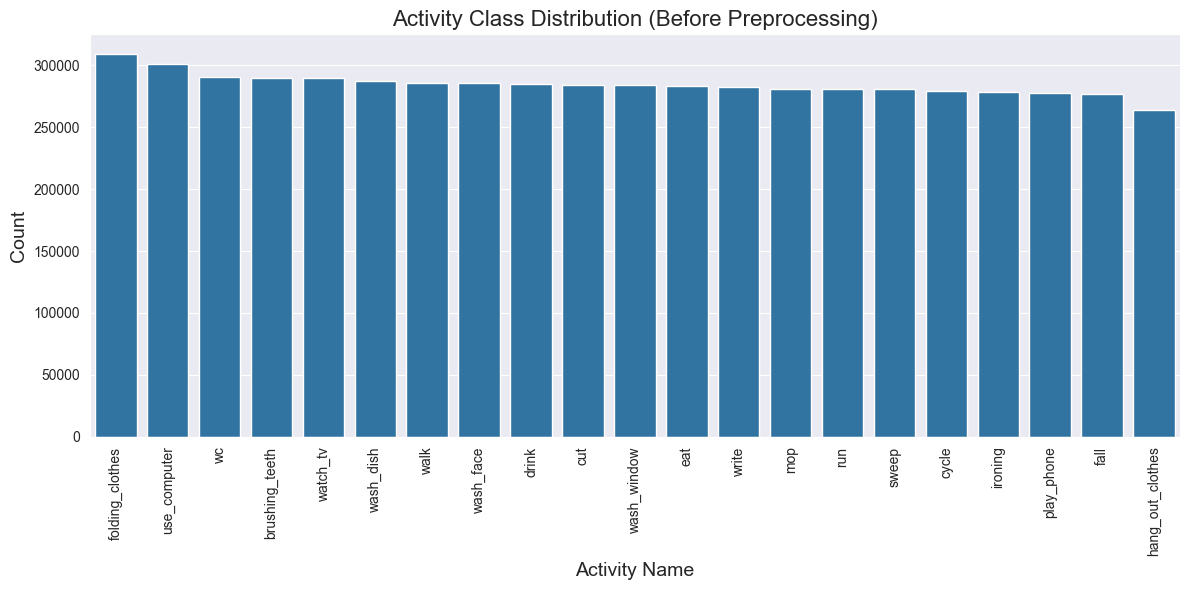

In [4]:
# Visualize class distribution before preprocessing
visualize_class_distribution(data, "Before Preprocessing", "subject_dependent_class_distribution_before_preprocessing.png")

In [5]:
# Normalize features
normalized_data = normalize_features(data)

In [6]:
# Print summary after normalization
print_summary(normalized_data, "After Normalization")


--- After Normalization Data Summary ---

               time            ax            ay            az            wx  \
count  5.976945e+06  5.976945e+06  5.976945e+06  5.976945e+06  5.976945e+06   
mean   1.678110e+12 -3.652012e-17  8.639290e-17 -6.333958e-17 -1.467462e-17   
std    5.212655e+09  1.000000e+00  1.000000e+00  1.000000e+00  1.000000e+00   
min    1.668425e+12 -3.978141e+01 -4.176038e+01 -5.420603e+01 -3.090283e+01   
25%    1.679049e+12 -6.386324e-01 -4.152323e-01 -6.548619e-01 -2.474855e-01   
50%    1.680783e+12 -2.043171e-02 -1.609952e-01 -3.959313e-02  1.962811e-03   
75%    1.681285e+12  5.816312e-01  2.640786e-01  6.798482e-01  2.555342e-01   
max    1.683204e+12  4.089998e+01  4.088418e+01  5.120676e+01  2.630330e+01   

                 wy            wz            ex            ey            ez  \
count  5.976945e+06  5.976945e+06  5.976945e+06  5.976945e+06  5.976945e+06   
mean   7.874650e-18 -5.197459e-18  1.311015e-17  1.308638e-17  5.325850e-19   
std    1

In [7]:
# Encode labels
normalized_data = encode_labels(normalized_data)

/tmp/ipykernel_114702/3037337463.py:92: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=activity_names, y=list(label_counts.values()), palette="viridis")


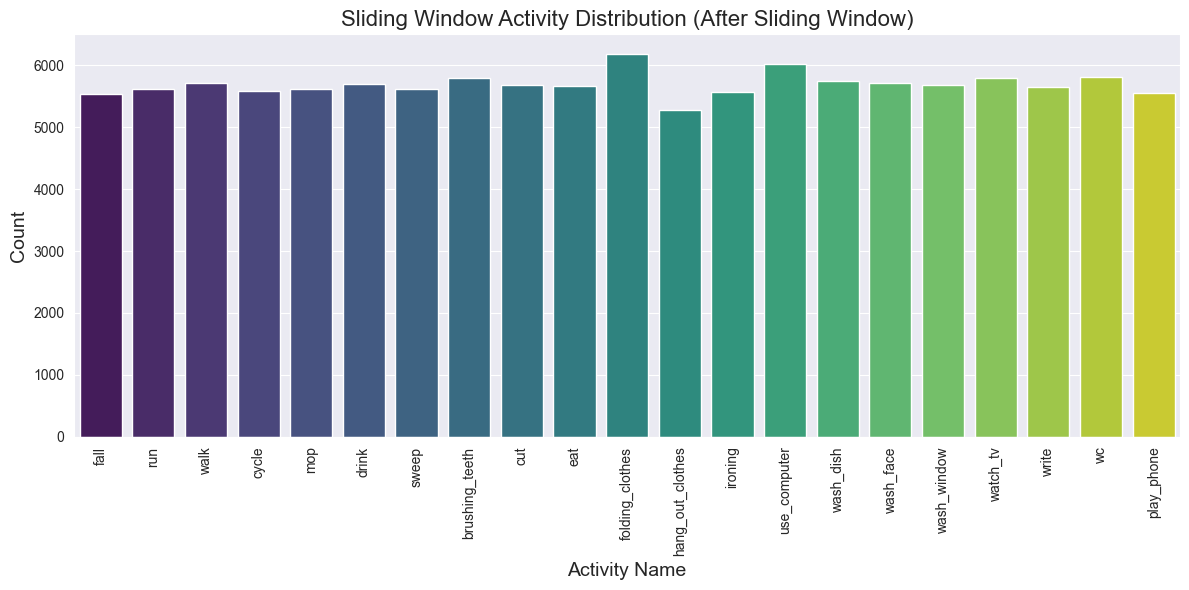

In [8]:
# Apply sliding window
X, y = apply_sliding_window(normalized_data)

# Visualize label distribution after applying sliding window
visualize_window_distribution(y, "After Sliding Window", "subject_dependent_sliding_window_label_distribution.png")